====================1. 数据获取与加载
====================1.1 加载数据
数据加载完毕 正常交易: 284315 条
数据加载完毕 异常交易: 492 条
====================2. 数据探索与预处理
====================2.1 处理不平衡数据
正常交易: 284315 条
异常交易: 492 条
采样后 样本数： 284807
采样后 正常比：99.83% 
采样后 异常比：0.17% 
====================2.2 特征标准化
====================3. 特征工程
====================3.1 基于领域知识的特征生成
====================3.2 降维（因V1-V28是降维后的匿名特征，故跳过此步）
====================4. 构建最终数据集
====================4.1 分割训练集与测试集
====================4.2 保存数据集
====================5. 验证数据集质量
====================5.1 可视化特征分布


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

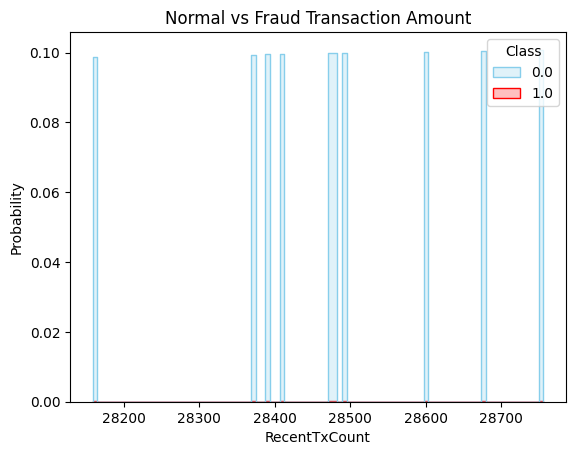

====================5.2 特征相关性分析


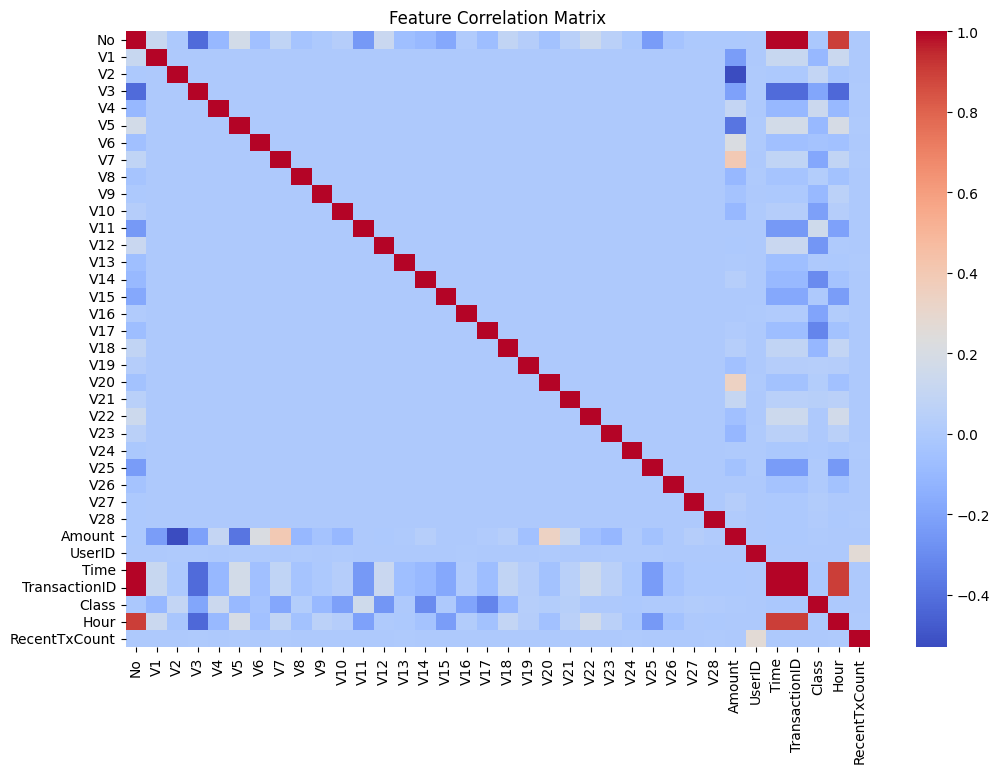

In [1]:
import pandas as pd

print("====================1. 数据获取与加载")
print("====================1.1 加载数据")
# 加载信用卡欺诈数据集（CSV格式）
data = pd.read_csv('/kaggle/input/abnormal-transaction-warning-system/creditcard.csv')
# 查看数据概况
# print(data.head())
print(f"数据加载完毕 正常交易: {data['Class'].value_counts()[0]} 条")
print(f"数据加载完毕 异常交易: {data['Class'].value_counts()[1]} 条")


print("====================2. 数据探索与预处理")
print("====================2.1 处理不平衡数据")
from sklearn.utils import resample

# ​分离特征与标签
X = data.drop('Class', axis=1)  # 特征（V1-V28、Amount、Time）
y = data['Class']               # 标签（0=正常，1=欺诈）
print(f"正常交易: {y.value_counts()[0]} 条")
print(f"异常交易: {y.value_counts()[1]} 条")
# ​标准化特征​（避免量纲差异影响采样效果）
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ​分离多数类与少数类
# 正常交易（多数类）
normal_indices = y[y == 0].index
normal_X = X_scaled[y == 0]
# 异常交易（少数类）
fraud_indices = y[y == 1].index
fraud_X = X_scaled[y == 1]

# ​使用SMOTE生成合成样本
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
fraud_X_resampled, fraud_y_resampled = smote.fit_resample(fraud_X, fraud_indices)
print("采样后 样本数：",(len(fraud_X_resampled) + len(normal_X)))
print("采样后 正常比：%.2f%% " % (len(normal_X) / (len(normal_X) + len(fraud_X_resampled))*100))
print("采样后 异常比：%.2f%% " % (len(fraud_X_resampled) / (len(normal_X) + len(fraud_X_resampled))*100))

# ​合并数据集
# 合并多数类原始样本与少数类合成样本
import numpy as np
X_combined = np.concatenate([normal_X, fraud_X_resampled], axis=0)
y_combined = np.concatenate([np.zeros(len(normal_X)), np.ones(len(fraud_X_resampled))], axis=0)

# 转换为DataFrame
data = pd.DataFrame(X_combined, columns=X.columns)
data['Class'] = y_combined


print("====================2.2 特征标准化")
from sklearn.preprocessing import StandardScaler

# 标准化金额特征（Amount）
# scaler = StandardScaler()                                                        #<<<<<<<<<<<<<<<<
# 计算均值和标准差（fit:mean+std） + 标准正态分布（transform）

# print("array_Amount_values 行:%r " % (len(data['Amount'].values.astype(int))))
# print("array_Amount_values.reshape(-1, 1) 行:%r " % (len(data['Amount'].values.reshape(-1, 1).astype(int))))

# data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))     #reshape(行，列) 当行/列不定时，可以设位 -1

# 删除无关列（如时间戳Time）
# data.drop(['Time'], axis=1, inplace=True)                                       #<<<<<<<<<<<<<<< 导致下一个命令错误


print("====================3. 特征工程")
print("====================3.1 基于领域知识的特征生成")
# 生成时间窗口特征（如小时段）
data['Hour'] = data['Time'] // 3600   # Time单位为秒
# 生成交易频率特征（如用户近期交易次数）
# 假设数据中有UserID列（实际需根据数据集调整）
data['RecentTxCount'] = data.groupby('UserID')['TransactionID'].transform('count')   # 分组聚合 *transform 前一个如果是多维注意lammdba是否返回Series
print("====================3.2 降维（因V1-V28是降维后的匿名特征，故跳过此步）")
'''
from sklearn.decomposition import PCA

# 对高维特征（V1-V28）进行PCA降维
# 若0<n_components<1，则n_components的值为主成分方差的阈值； 通过设置该变量，即可调整主成分数量K；
# 若n_components≥1，则降维后的特征数为n_components；
# whiten：参数为bool型，是否对降维后的数据的每个特征进行归一化，默认是False
pca = PCA(n_components=28)
# fit(X,y=None) ：用训练数据X训练模型，由于PCA是无监督降维，因此y=None。
# transform(X,y=None) ：训练好模型后，对输入数据X进行降维。
# fit_transform(X) ：用训练数据X训练模型，并对X进行降维。相当于先用fit(X)，再用transform(X)。
# inverse_transform(X) ：将降维后的数据还原成原始数据的近似。(PCA的重建)
pca_features = pca.fit_transform(data[[f'V{i}' for i in range(1, 29)]])  

# 将降维结果合并到数据集
data_pca = pd.DataFrame(pca_features, columns=[f'PC{i}' for i in range(1, 29)])  # i的范围 1- （n_components+1）
data_pca.to_csv('data_pca.csv',columns=[f'PC{i}' for i in range(1, 29)])   #保存降维过的文件，以便本地对比
data = pd.concat([data, data_pca], axis=1)  # axis= 0(Y轴：默认)/1(x轴)      
'''


print("====================4. 构建最终数据集")
print("====================4.1 分割训练集与测试集")
from sklearn.model_selection import train_test_split
X = data.drop('Class', axis=1)
y = data['Class']

# 分层抽样保持类别比例
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("====================4.2 保存数据集")
# 保存为CSV或Pickle
X_train.to_csv('train_features.csv', index=False)
y_train.to_csv('train_labels.csv', index=False)
X_test.to_csv('test_features.csv', index=False)
y_test.to_csv('test_labels.csv', index=False)

print("====================5. 验证数据集质量")
print("====================5.1 可视化特征分布")
import seaborn as sns
import matplotlib.pyplot as plt
# 绘制正常与异常交易的金额分布对比
# rug ： 在轴上显示数据点分布（需配合kde使用）
# cumulative ： 是否绘制累积分布图	
# binwidth ： 单独指定柱宽而非数量	


sns.histplot(data=data, 
             x='RecentTxCount',  # RecentTxCount：交易频率特征  ； Amount：金额
             hue='Class',# 通过label区分正常/异常[1,2]
             element='step',  # 柱形样式（bars：默认、step：阶梯状、poly：多边形）
             kde=False,  #启用核密度估计，直观展示概率密度 
             # bins=10,    #控制分箱数量，建议根据数据量调整（默认自动计算）。数字越大粒度越小
             stat='probability', #统计量类型（count:默认、density:归一化、probability:概率 , percent:报告的可读性）
             palette=["skyblue", "red"]  ) #自定义颜色
plt.title('Normal vs Fraud Transaction Amount')
plt.show()

print("====================5.2 特征相关性分析")
# 计算特征相关性矩阵
corr_matrix = data.corr()
# 绘制热力图
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Feature Correlation Matrix')
plt.show()
